### Python Code for detecting boundry of cortical layer acounting for the curvature of the brain 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation
from skimage.segmentation import active_contour
from scipy.ndimage import gaussian_filter

# Load the Nissl-stained brain image
image = cv2.imread("nissl_stain.jpg", cv2.IMREAD_GRAYSCALE)  # Replace with actual image

# Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
image_enhanced = clahe.apply(image)

# Apply Gaussian blur to smooth the image
blurred = gaussian_filter(image_enhanced, sigma=2)

# Use Hessian filter for ridge detection (better for layer transitions)
hessian = filters.hessian(blurred)

# Normalize and threshold to extract layer boundaries
hessian = (hessian / hessian.max() * 255).astype(np.uint8)
_, thresh = cv2.threshold(hessian, 30, 255, cv2.THRESH_BINARY)

# Find contours (potential cortical layers)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours from top to bottom (to identify layers properly)
contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1])

# Convert image to RGB for visualization
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Initialize an empty list for refined contours
refined_layers = []

# Fit active contours (snakes) to each detected layer
for contour in contours[:7]:  # Consider first 6-7 boundaries
    contour = contour.squeeze()  # Remove unnecessary dimensions
    
    if len(contour) < 5:  # Skip small/noisy contours
        continue

    # Create initial snake (polygon approximation of contour)
    snake = np.array(contour, dtype=np.float64)

    # Apply active contour model (snakes) to refine layer detection
    snake = active_contour(blurred, snake, alpha=0.1, beta=1.5, gamma=0.1)

    refined_layers.append(snake)

# Draw the refined cortical layers
for snake in refined_layers:
    snake = snake.astype(np.int32)
    for i in range(len(snake) - 1):
        cv2.line(output, tuple(snake[i]), tuple(snake[i + 1]), (0, 255, 0), 2)  # Green for layers

# Display Results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Nissl-Stained Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Curvature-Adaptive Cortical Layers")
plt.imshow(output)

plt.show()


### Making Otsu Image 

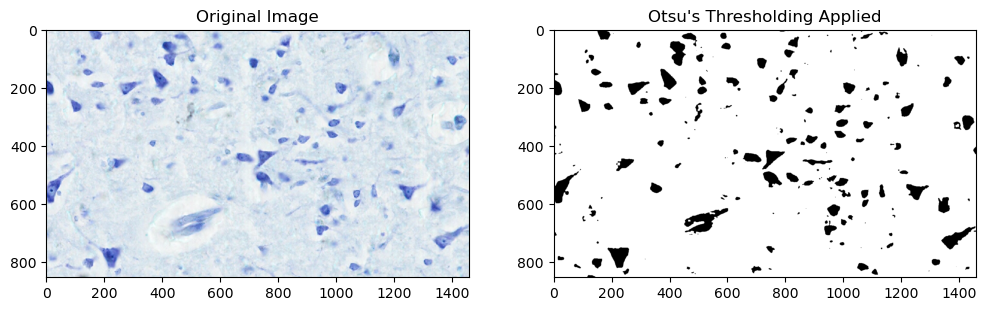

Processed image saved as: processed_nissl_otsu.png


In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Load the Nissl-stained image (Replace with your file path)
image_path = r"C:\Users\srira\OneDrive\Documents\conda\Brain Center\Screenshot 2025-01-31 142031.png" # Update with your actual image file
image = cv2.imread(image_path)

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise before thresholding
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply Otsu's Thresholding for automatic segmentation
_, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Apply morphological operations (Opening) to remove small noise
kernel = np.ones((3, 3), np.uint8)
cleaned_otsu = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Save processed image
output_path = "processed_nissl_otsu.png"
cv2.imwrite(output_path, cleaned_otsu)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Otsu's Thresholding Applied")
plt.imshow(cleaned_otsu, cmap='gray')

plt.show()

print(f"Processed image saved as: {output_path}")



Original image loaded successfully!
Otsu mask loaded successfully!


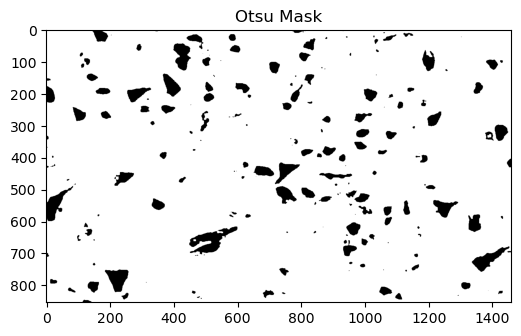

Restored white background image saved successfully as: C:\Users\srira\OneDrive\Documents\conda\Brain Center\restored_white_background.png


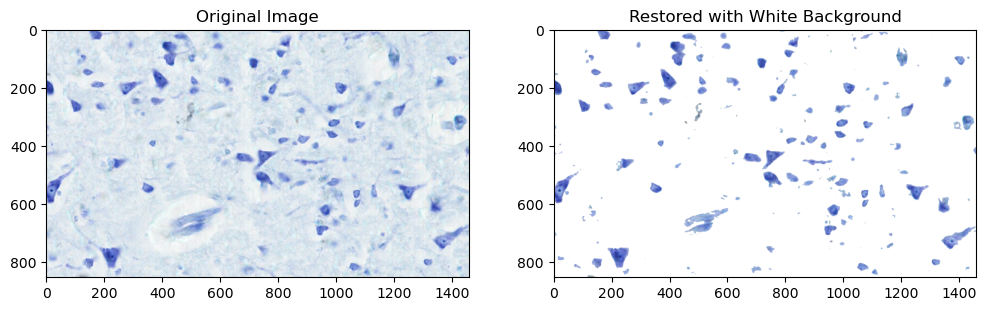

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define file paths
original_image_path = r"C:\Users\srira\OneDrive\Documents\conda\Brain Center\Screenshot 2025-01-31 142031.png"  # Replace with actual file path
otsu_image_path = r"processed_nissl_otsu.png"  # Replace with actual file path

# Check if the original image exists
if not os.path.exists(original_image_path):
    print(f"Error: The original image at {original_image_path} does not exist.")
else:
    original_image = cv2.imread(original_image_path)
    if original_image is None:
        print("Error: Original image not loaded correctly.")
    else:
        print("Original image loaded successfully!")

# Check if the Otsu image exists
if not os.path.exists(otsu_image_path):
    print(f"Error: The Otsu processed image at {otsu_image_path} does not exist.")
else:
    otsu_mask = cv2.imread(otsu_image_path, cv2.IMREAD_GRAYSCALE)
    if otsu_mask is None:
        print("Error: Otsu mask not loaded correctly.")
    else:
        print("Otsu mask loaded successfully!")

        # Ensure the mask is binary (black = keep, white = remove)
        _, binary_mask = cv2.threshold(otsu_mask, 128, 255, cv2.THRESH_BINARY)

        # Display the mask for debugging
        plt.figure(figsize=(6, 6))
        plt.title("Otsu Mask")
        plt.imshow(binary_mask, cmap='gray')
        plt.show()

        # Invert the mask so black areas are kept and white areas are removed
        inverted_mask = cv2.bitwise_not(binary_mask)

        # Convert mask to 3 channels (so it matches the original image)
        inverted_mask_3ch = cv2.cvtColor(inverted_mask, cv2.COLOR_GRAY2BGR)

        # Apply the mask to the original image
        black_restored_image = cv2.bitwise_and(original_image, inverted_mask_3ch)

        # Create a white background image
        white_background = np.ones_like(original_image) * 255  # Create a completely white image

        # Combine the white background with the masked original image
        final_image = np.where(inverted_mask_3ch == 0, white_background, black_restored_image)

        # Define the output file path for the image with the white background restored
        restored_image_path = r"C:\Users\srira\OneDrive\Documents\conda\Brain Center\restored_white_background.png"  # Update with your desired output path

        # Save the restored image and check if it was saved successfully
        if cv2.imwrite(restored_image_path, final_image):
            print(f"Restored white background image saved successfully as: {restored_image_path}")
        else:
            print(f"Error: Image not saved. Please check the path and permissions.")

        # Display results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))

        plt.subplot(1, 2, 2)
        plt.title("Restored with White Background")
        plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))

        plt.show()



### Restored Image 

Saved restored image to: /mnt/data/restored_white_background.png
Saved restored image to: restored_white_background_debug.png


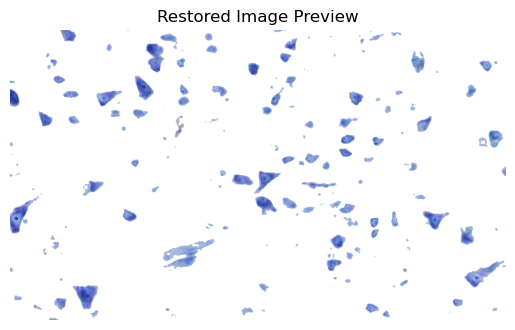

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original Nissl-stained image
original_image_path = r"C:\Users\srira\OneDrive\Documents\conda\Brain Center\Screenshot 2025-01-31 142031.png"  # Replace with actual file path
original_image = cv2.imread(original_image_path)

# Load the Otsu-processed binary image (black = cells, white = background)
otsu_image_path = r"processed_nissl_otsu.png"  # Replace with actual file path
otsu_mask = cv2.imread(otsu_image_path, cv2.IMREAD_GRAYSCALE)

# Ensure images are loaded correctly
if original_image is None:
    raise FileNotFoundError(f"Error: Could not load original image from {original_image_path}")

if otsu_mask is None:
    raise FileNotFoundError(f"Error: Could not load Otsu mask from {otsu_image_path}")

# Ensure the mask is binary (black = keep, white = remove)
_, binary_mask = cv2.threshold(otsu_mask, 128, 255, cv2.THRESH_BINARY)

# Invert the mask so black areas are kept and white areas are removed
inverted_mask = cv2.bitwise_not(binary_mask)

# Convert mask to 3 channels (so it matches the original image)
inverted_mask_3ch = cv2.cvtColor(inverted_mask, cv2.COLOR_GRAY2BGR)

# Apply the mask to the original image
black_restored_image = cv2.bitwise_and(original_image, inverted_mask_3ch)

# Create a white background image
white_background = np.ones_like(original_image) * 255  # Create a completely white image

# Combine the white background with the masked original image
final_image = np.where(inverted_mask_3ch == 0, white_background, black_restored_image)

# Save the restored image in multiple locations for debugging
restored_image_path_1 = "/mnt/data/restored_white_background.png"
restored_image_path_2 = "restored_white_background_debug.png"

cv2.imwrite(restored_image_path_1, final_image)
cv2.imwrite(restored_image_path_2, final_image)

print(f"Saved restored image to: {restored_image_path_1}")
print(f"Saved restored image to: {restored_image_path_2}")

# Show the restored image for verification
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))
plt.title("Restored Image Preview")
plt.axis("off")
plt.show()

### Nucleolus Detection


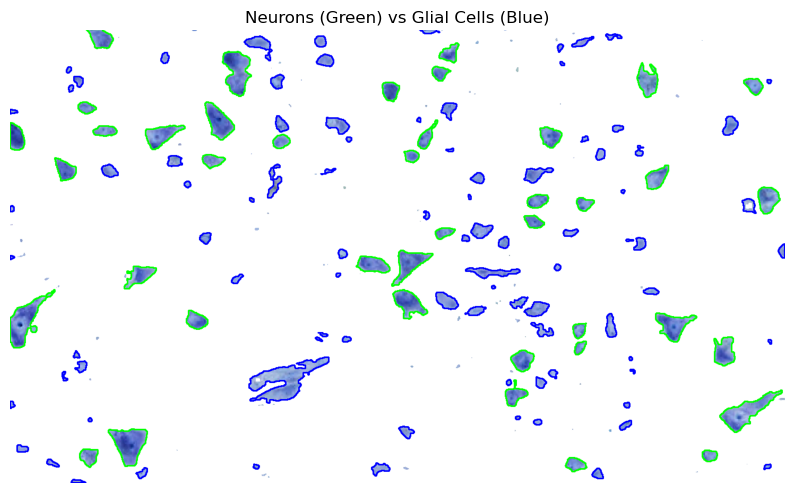

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original color image
image_path = "restored_white_background_debug.png"
image = cv2.imread(image_path)


# Check if the image was loaded successfully
if image is None:
    raise ValueError("Image not found or unable to load.")

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Improve contrast using CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
gray = clahe.apply(gray)

# Apply Otsu's thresholding
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Morphological operations to refine segmentation
kernel = np.ones((3, 3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
output = image.copy()

# List to store intensity values for global threshold calculation
all_nucleolus_intensities = []

# Process each detected cell
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 30:
        continue

    # Create mask for each cell
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    # Dilate slightly to ensure better boundary capture
    mask_dilated = cv2.dilate(mask, kernel, iterations=1)

    # Extract region inside the cell
    roi = cv2.bitwise_and(image, image, mask=mask_dilated)

    # Convert ROI to grayscale for nucleolus detection
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    
    # Extract only relevant pixel intensities
    nucleolus_pixels = roi_gray[mask_dilated == 255]
    
    if len(nucleolus_pixels) == 0:
        continue

    # Use mean intensity instead of min/percentile
    mean_intensity = np.mean(nucleolus_pixels)
    std_dev = np.std(nucleolus_pixels)  # Standard deviation helps set a better threshold
    all_nucleolus_intensities.append(mean_intensity)

# **Global Classification Threshold Calculation**
global_threshold = np.mean(all_nucleolus_intensities) - (0.5 * np.std(all_nucleolus_intensities))

# Process contours again with the new classification threshold
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 30:
        continue

    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
    mask_dilated = cv2.dilate(mask, kernel, iterations=1)

    roi = cv2.bitwise_and(image, image, mask=mask_dilated)
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    nucleolus_pixels = roi_gray[mask_dilated == 255]

    if len(nucleolus_pixels) == 0:
        continue

    mean_intensity = np.mean(nucleolus_pixels)

    # Classify based on the **global threshold**
    if mean_intensity < global_threshold:
        color = (0, 255, 0)  # Green for neurons
    else:
        color = (255, 0, 0)  # Blue for glial cells

    cv2.drawContours(output, [cnt], -1, color, 2)

# Show final output
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
plt.title("Neurons (Green) vs Glial Cells (Blue)")
plt.axis("off")
plt.show()

### Cell Classification 

Cell Features Table:
     Cell Number         Cell Type    Area   Perimeter  Major Axis Length  \
0              1  Pyramidal Neuron  1255.0  147.982756          49.747462   
1              2         Microglia   228.0   72.727922          32.114320   
2              3         Microglia   203.0   77.112698          32.737876   
3              4   Oligodendrocyte   379.0   70.284271          22.729234   
4              5  Pyramidal Neuron   861.0  142.568542          52.004324   
..           ...               ...     ...         ...                ...   
116          117   Oligodendrocyte    76.0   30.485281          11.172082   
117          118   Oligodendrocyte    88.0   34.485281          13.837417   
118          119         Microglia   241.0   65.698485          24.354868   
119          120   Oligodendrocyte   289.0   65.112698          21.572100   
120          121         Microglia   135.0   57.520815          27.326301   

     Minor Axis Length  Soma Diameter  Aspect Ratio  C

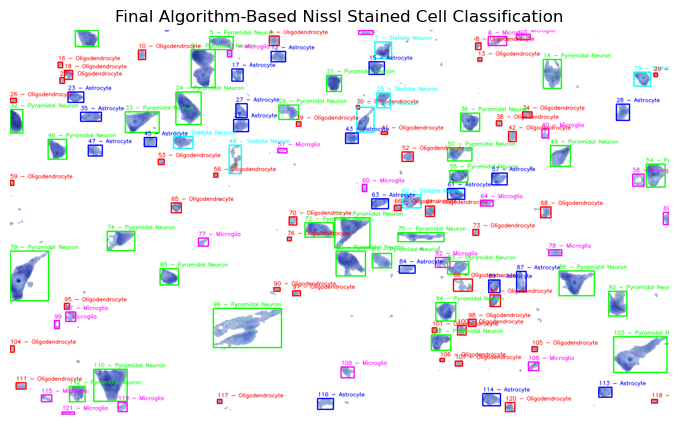

✅ CSV Data Saved: data cell.csv
✅ Final Image Saved: /mnt/data/final_classified_nissl_cells.png


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops, label

# Load Nissl-Stained Image
image_path = "restored_white_background_debug.png" 
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Adaptive Thresholding for Better Segmentation
_, binary_cells = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small artifacts with morphological operations
kernel = np.ones((3, 3), np.uint8)
binary_cells = cv2.morphologyEx(binary_cells, cv2.MORPH_OPEN, kernel)

# Label the segmented regions
labeled_cells = label(binary_cells)
regions = regionprops(labeled_cells)

# Define Cell Types & Colors
cell_colors = {
    "Pyramidal Neuron": (0, 255, 0),   # Green
    "Stellate Neuron": (255, 255, 0),  # Yellow
    "Astrocyte": (255, 0, 0),          # Red
    "Oligodendrocyte": (0, 0, 255),    # Blue
    "Microglia": (255, 0, 255)         # Magenta
}

# **Improved Rule-Based Classification with Most Probable Category**
def classify_cell(region, cell_region):
    area = region.area
    perimeter = max(region.perimeter, 1)
    aspect_ratio = region.major_axis_length / max(region.minor_axis_length, 1)
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    solidity = region.solidity
    mean_intensity = np.mean(cell_region)
    nucleolus_present = 1 if np.min(cell_region) < 100 else 0  # Adjusted nucleolus threshold

    # **Strict Classification Rules**
    if area > 850 and aspect_ratio > 1.3 and nucleolus_present and circularity < 0.65:
        return "Pyramidal Neuron"

    elif 550 < area < 850 and 1.1 < aspect_ratio < 1.5 and circularity < 0.7:
        return "Stellate Neuron"

    elif 400 < area < 750 and circularity > 0.5 and mean_intensity > 70:
        return "Astrocyte"

    elif area < 550 and circularity > 0.75 and mean_intensity > 90:
        return "Oligodendrocyte"

    elif area < 400 and circularity > 0.6 and mean_intensity > 80:
        return "Microglia"

    # **Fallback: Assign to the Closest Matching Cell Type**
    distances = {
        "Pyramidal Neuron": abs(area - 900) + abs(aspect_ratio - 1.5) + abs(mean_intensity - 60),
        "Stellate Neuron": abs(area - 700) + abs(aspect_ratio - 1.3) + abs(mean_intensity - 75),
        "Astrocyte": abs(area - 600) + abs(circularity - 0.6) + abs(mean_intensity - 85),
        "Oligodendrocyte": abs(area - 500) + abs(circularity - 0.8) + abs(mean_intensity - 95),
        "Microglia": abs(area - 350) + abs(circularity - 0.65) + abs(mean_intensity - 90)
    }

    return min(distances, key=distances.get)  # Assign the cell to the category with the smallest "distance"

# Prepare Data Storage for CSV and Table
cell_data = []

# Apply Rule-Based Classification and Assign Numbers
cell_number = 1  # Starting number for cell labeling
for region in regions:
    if region.area < 50:  # Ignore very small artifacts
        continue

    minr, minc, maxr, maxc = region.bbox
    cell_region = enhanced[minr:maxr, minc:maxc]  # Extract cell region

    # Classify Cell
    cell_type = classify_cell(region, cell_region)
    color = cell_colors.get(cell_type, (255, 255, 255))  # Default white if not found

    # Draw Bounding Box, Label and Number for Cell
    cv2.rectangle(image, (minc, minr), (maxc, maxr), color, 2)
    cv2.putText(image, f"{cell_number} - {cell_type}", (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)

    # Add Data for CSV and Table
    cell_data.append({
        "Cell Number": cell_number,
        "Cell Type": cell_type,
        "Area": region.area,
        "Perimeter": region.perimeter,
        "Major Axis Length": region.major_axis_length,
        "Minor Axis Length": region.minor_axis_length,
        "Soma Diameter": region.equivalent_diameter,  # Approximation
        "Aspect Ratio": region.major_axis_length / max(region.minor_axis_length, 1),
        "Circularity": (4 * np.pi * region.area) / (region.perimeter ** 2),
        "Solidity": region.solidity,
        "Nucleolus Present": 1 if np.min(cell_region) < 100 else 0
    })

    cell_number += 1  # Increment Cell Number

# Convert Data to DataFrame for Display and Save
df = pd.DataFrame(cell_data)

# Display Table in Output
print("Cell Features Table:")
print(df)

# Save Data to CSV
csv_path = "data cell.csv"
df.to_csv(csv_path, index=False)

# Save Final Image
output_image_path = "/mnt/data/final_classified_nissl_cells.png"
cv2.imwrite(output_image_path, image)

# Display Image
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Final Algorithm-Based Nissl Stained Cell Classification")
plt.axis("off")
plt.show()

# Output Paths
print(f"✅ CSV Data Saved: {csv_path}")
print(f"✅ Final Image Saved: {output_image_path}")


### Calculating density 

In [4]:
import cv2
import numpy as np
from skimage.measure import regionprops, label

# Load the final classified image (replace with actual path)
image_path = "/mnt/data/final_classified_nissl_cells.png"
image = cv2.imread(image_path)

# Convert the image to grayscale (for segmentation purposes)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold to get binary image (assuming the cells are dark on a lighter background)
_, binary_cells = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Label the segmented regions
labeled_cells = label(binary_cells)

# Define Cell Types
cell_types = ["Pyramidal Neuron", "Stellate Neuron", "Astrocyte", "Oligodendrocyte", "Microglia"]

# Cell Color Mapping for Identifying Cell Types (based on your classification)
cell_colors = {
    "Pyramidal Neuron": (0, 255, 0),   # Green
    "Stellate Neuron": (255, 255, 0),  # Yellow
    "Astrocyte": (255, 0, 0),          # Red
    "Oligodendrocyte": (0, 0, 255),    # Blue
    "Microglia": (255, 0, 255)         # Magenta
}

# Initialize variables to hold counts and areas for each cell type
cell_count = {cell_type: 0 for cell_type in cell_types}
cell_area = {cell_type: 0 for cell_type in cell_types}

# Get the total area of the image
image_area = image.shape[0] * image.shape[1]  # Height * Width

# Extract regions and classify cells based on color in the image
for region in regionprops(labeled_cells):
    minr, minc, maxr, maxc = region.bbox
    cell_region = image[minr:maxr, minc:maxc]  # Extract cell region

    # Find the dominant color in the cell region (this determines the cell type)
    mean_color = np.mean(cell_region, axis=(0, 1))  # Average color in the region
    if np.allclose(mean_color, cell_colors["Pyramidal Neuron"], atol=50):
        cell_type = "Pyramidal Neuron"
    elif np.allclose(mean_color, cell_colors["Stellate Neuron"], atol=50):
        cell_type = "Stellate Neuron"
    elif np.allclose(mean_color, cell_colors["Astrocyte"], atol=50):
        cell_type = "Astrocyte"
    elif np.allclose(mean_color, cell_colors["Oligodendrocyte"], atol=50):
        cell_type = "Oligodendrocyte"
    elif np.allclose(mean_color, cell_colors["Microglia"], atol=50):
        cell_type = "Microglia"

    # Increment cell count and accumulate area
    cell_count[cell_type] += 1
    cell_area[cell_type] += region.area

# Calculate densities for each cell type and the total density
cell_density = {}
for cell_type in cell_types:
    density = cell_count[cell_type] / image_area * 10000  # Density per 10,000 pixels
    cell_density[cell_type] = density

# Calculate total cell density (for all cell types)
total_cells = sum(cell_count.values())
total_density = total_cells / image_area * 10000  # Density per 10,000 pixels

# Display the results
print(f"Cell Densities (per 10,000 pixels):")
for cell_type, density in cell_density.items():
    print(f"{cell_type}: {density:.2f} cells/10,000 pixels")

print(f"Total Cell Density: {total_density:.2f} cells/10,000 pixels")



Cell Densities (per 10,000 pixels):
Pyramidal Neuron: 5.87 cells/10,000 pixels
Stellate Neuron: 3.42 cells/10,000 pixels
Astrocyte: 0.00 cells/10,000 pixels
Oligodendrocyte: 0.26 cells/10,000 pixels
Microglia: 3.00 cells/10,000 pixels
Total Cell Density: 12.56 cells/10,000 pixels


### Probability calculation

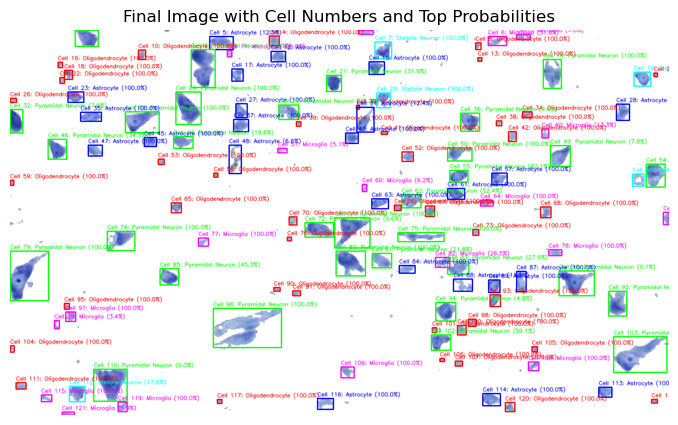

✅ CSV Report Saved: /mnt/data/cell_classifications_with_probabilities.csv
✅ Final Image Saved: /mnt/data/final_classified_cells_with_probabilities.png


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops, label

# Load Nissl-Stained Image
image_path = "restored_white_background_debug.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Adaptive Thresholding for Better Segmentation
_, binary_cells = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small artifacts with morphological operations
kernel = np.ones((3, 3), np.uint8)
binary_cells = cv2.morphologyEx(binary_cells, cv2.MORPH_OPEN, kernel)

# Label the segmented regions
labeled_cells = label(binary_cells)
regions = regionprops(labeled_cells)

# Define Cell Types & Colors
cell_colors = {
    "Pyramidal Neuron": (0, 255, 0),   # Green
    "Stellate Neuron": (255, 255, 0),  # Yellow
    "Astrocyte": (255, 0, 0),          # Red
    "Oligodendrocyte": (0, 0, 255),    # Blue
    "Microglia": (255, 0, 255)         # Magenta
}

# **Improved Rule-Based Classification with Most Probable Category**
def classify_cell(region, cell_region):
    area = region.area
    perimeter = max(region.perimeter, 1)
    aspect_ratio = region.major_axis_length / max(region.minor_axis_length, 1)
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    solidity = region.solidity
    mean_intensity = np.mean(cell_region)
    nucleolus_present = 1 if np.min(cell_region) < 100 else 0  # Adjusted nucleolus threshold

    # **Strict Classification Rules**
    if area > 850 and aspect_ratio > 1.3 and nucleolus_present and circularity < 0.65:
        return "Pyramidal Neuron", {"Pyramidal Neuron": 1.0}
    elif 550 < area < 850 and 1.1 < aspect_ratio < 1.5 and circularity < 0.7:
        return "Stellate Neuron", {"Stellate Neuron": 1.0}
    elif 400 < area < 750 and circularity > 0.5 and mean_intensity > 70:
        return "Astrocyte", {"Astrocyte": 1.0}
    elif area < 550 and circularity > 0.75 and mean_intensity > 90:
        return "Oligodendrocyte", {"Oligodendrocyte": 1.0}
    elif area < 400 and circularity > 0.6 and mean_intensity > 80:
        return "Microglia", {"Microglia": 1.0}

    # **Fallback: Compute Probabilities Based on Features**
    probabilities = {
        "Pyramidal Neuron": np.exp(-abs(area - 900)/200) * np.exp(-abs(aspect_ratio - 1.5)/0.3),
        "Stellate Neuron": np.exp(-abs(area - 700)/200) * np.exp(-abs(aspect_ratio - 1.3)/0.3),
        "Astrocyte": np.exp(-abs(area - 600)/150) * np.exp(-abs(circularity - 0.6)/0.2),
        "Oligodendrocyte": np.exp(-abs(area - 500)/150) * np.exp(-abs(circularity - 0.8)/0.2),
        "Microglia": np.exp(-abs(area - 350)/100) * np.exp(-abs(circularity - 0.65)/0.2)
    }

    return "Fallback", probabilities

# Prepare Data Storage for CSV and Report
cell_data = []

# Apply Rule-Based Classification and Assign Numbers
cell_number = 1  # Starting number for cell labeling
for region in regions:
    if region.area < 50:  # Ignore very small artifacts
        continue

    minr, minc, maxr, maxc = region.bbox
    cell_region = enhanced[minr:maxr, minc:maxc]  # Extract cell region

    # Classify Cell and Get Probabilities
    cell_type, probabilities = classify_cell(region, cell_region)

    # Get the top 1 cell type by probability
    top_cell_type = max(probabilities, key=probabilities.get)
    top_probability = probabilities[top_cell_type] * 100  # Convert to percentage

    # Get the color for the top cell type
    color = cell_colors.get(top_cell_type, (255, 255, 255))  # Default to white if not found

    # Draw the Cell Number with the top probability color
    cell_number_text = f"Cell {cell_number}: {top_cell_type} ({top_probability:.1f}%)"
    cv2.putText(image, cell_number_text, (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)

    # Draw bounding box for the cell
    cv2.rectangle(image, (minc, minr), (maxc, maxr), color, 2)

    # Add to the data for CSV report
    cell_data.append({
        "Cell Number": cell_number,
        "Cell Type": top_cell_type,
        "Probability": f"{top_probability:.1f}%"
    })

    cell_number += 1  # Increment Cell Number

# Convert Data to DataFrame for Display and Save
df = pd.DataFrame(cell_data)

# Save Data to CSV
csv_path = "/mnt/data/cell_classifications_with_probabilities.csv"
df.to_csv(csv_path, index=False)

# Save Final Image with Cell Numbers and Top Probability
output_image_path = "/mnt/data/final_classified_cells_with_probabilities.png"
cv2.imwrite(output_image_path, image)

# Display the Final Image
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Final Image with Cell Numbers and Top Probabilities")
plt.axis("off")
plt.show()

# Output Paths
print(f"✅ CSV Report Saved: {csv_path}")
print(f"✅ Final Image Saved: {output_image_path}")


In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops, label
import os

# Load Nissl-Stained Image
image_path = "restored_white_background_debug.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Adaptive Thresholding for Better Segmentation
_, binary_cells = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small artifacts with morphological operations
kernel = np.ones((3, 3), np.uint8)
binary_cells = cv2.morphologyEx(binary_cells, cv2.MORPH_OPEN, kernel)

# Label the segmented regions
labeled_cells = label(binary_cells)
regions = regionprops(labeled_cells)

# Define Cell Types & Colors
cell_colors = {
    "Pyramidal Neuron": (0, 255, 0),   # Green
    "Stellate Neuron": (255, 255, 0),  # Yellow
    "Astrocyte": (255, 0, 0),          # Red
    "Oligodendrocyte": (0, 0, 255),    # Blue
    "Microglia": (255, 0, 255)         # Magenta
}

# **Improved Rule-Based Classification with Most Probable Category**
def classify_cell(region, cell_region):
    area = region.area
    perimeter = max(region.perimeter, 1)
    aspect_ratio = region.major_axis_length / max(region.minor_axis_length, 1)
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    solidity = region.solidity
    mean_intensity = np.mean(cell_region)
    nucleolus_present = 1 if np.min(cell_region) < 100 else 0  # Adjusted nucleolus threshold

    # **Strict Classification Rules**
    if area > 850 and aspect_ratio > 1.3 and nucleolus_present and circularity < 0.65:
        return "Pyramidal Neuron", {"Pyramidal Neuron": 1.0}
    elif 550 < area < 850 and 1.1 < aspect_ratio < 1.5 and circularity < 0.7:
        return "Stellate Neuron", {"Stellate Neuron": 1.0}
    elif 400 < area < 750 and circularity > 0.5 and mean_intensity > 70:
        return "Astrocyte", {"Astrocyte": 1.0}
    elif area < 550 and circularity > 0.75 and mean_intensity > 90:
        return "Oligodendrocyte", {"Oligodendrocyte": 1.0}
    elif area < 400 and circularity > 0.6 and mean_intensity > 80:
        return "Microglia", {"Microglia": 1.0}

    # **Fallback: Compute Probabilities Based on Features**
    probabilities = {
        "Pyramidal Neuron": np.exp(-abs(area - 900)/200) * np.exp(-abs(aspect_ratio - 1.5)/0.3),
        "Stellate Neuron": np.exp(-abs(area - 700)/200) * np.exp(-abs(aspect_ratio - 1.3)/0.3),
        "Astrocyte": np.exp(-abs(area - 600)/150) * np.exp(-abs(circularity - 0.6)/0.2),
        "Oligodendrocyte": np.exp(-abs(area - 500)/150) * np.exp(-abs(circularity - 0.8)/0.2),
        "Microglia": np.exp(-abs(area - 350)/100) * np.exp(-abs(circularity - 0.65)/0.2)
    }

    return "Fallback", probabilities

# Prepare Data Storage for CSV and Report
cell_data = []

# Apply Rule-Based Classification and Assign Numbers
cell_number = 1  # Starting number for cell labeling
for region in regions:
    if region.area < 50:  # Ignore very small artifacts
        continue

    minr, minc, maxr, maxc = region.bbox
    cell_region = enhanced[minr:maxr, minc:maxc]  # Extract cell region

    # Classify Cell and Get Probabilities
    cell_type, probabilities = classify_cell(region, cell_region)

    # Sort probabilities in descending order
    sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    # Get coordinates (centroid)
    centroid_x, centroid_y = region.centroid

    # Collect top 5 classifications and probabilities
    top_classes = [item[0] for item in sorted_probabilities[:5]]
    top_probabilities = [f"{item[1]*100:.1f}%" for item in sorted_probabilities[:5]]

    # Ensure we have 5 entries even if there are fewer than 5 classifications
    while len(top_classes) < 5:
        top_classes.append("N/A")
        top_probabilities.append("N/A")

    # Add data for CSV
    cell_data.append({
        "Cell Number": cell_number,
        "X Coordinate": centroid_x,
        "Y Coordinate": centroid_y,
        "Top 1 Class": top_classes[0],
        "Top 1 Probability": top_probabilities[0],
        "Top 2 Class": top_classes[1],
        "Top 2 Probability": top_probabilities[1],
        "Top 3 Class": top_classes[2],
        "Top 3 Probability": top_probabilities[2],
        "Top 4 Class": top_classes[3],
        "Top 4 Probability": top_probabilities[3],
        "Top 5 Class": top_classes[4],
        "Top 5 Probability": top_probabilities[4]
    })

    cell_number += 1  # Increment Cell Number

# Create "Brain Lab" folder if not exists
folder_path = "Brain Lab"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Save Data to CSV in the "Brain Lab" folder
csv_path = os.path.join(folder_path, "cell_classifications_with_top_5_probabilities.csv")
df = pd.DataFrame(cell_data)
df.to_csv(csv_path, index=False)

# Output path for CSV
print(f"✅ CSV Report Saved: {csv_path}")


✅ CSV Report Saved: Brain Lab\cell_classifications_with_top_5_probabilities.csv


### Other data Extraction

        Area     Perimeter   Major Axis   Aspect Ratio  Circularity  Solidity  \
0  1162686.0  17394.179198  1686.391006       1.706951     0.048291  0.932506   
1      108.0     39.723212    14.122959       1.383909     0.860092  0.915254   
2        1.0      2.681517     0.000000       0.000000     1.747627  1.000000   
3        6.0      8.369874     3.265986       1.632985     1.076275  1.000000   
4        3.0      6.473755     3.265986  326598.632371     0.899536  1.000000   

    Intensity  Soma Density  Soma Diameter   Contrast    Energy  Homogeneity  \
0  237.783311     66.843395    3376.723485  56.805846  1.185298     0.963941   
1  208.636364      2.718813      12.185376  56.805846  1.185298     0.963941   
2  205.000000      0.372922       0.990966  56.805846  1.185298     0.963941   
3  202.333333      0.716856       2.714083  56.805846  1.185298     0.963941   
4  205.000000      0.463409       2.007535  56.805846  1.185298     0.963941   

          Cell Type  
0  Pyramid

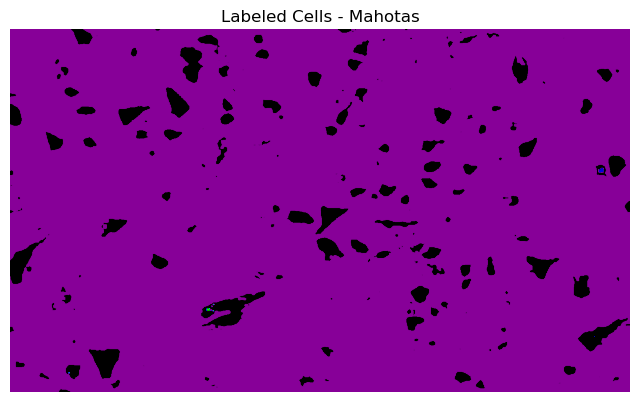

In [27]:
import numpy as np
import mahotas as mh
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import regionprops, label

# Load Preprocessed Image
image_path = "restored_white_background_debug.png"   # Update with the actual image path
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Ensure 2D grayscale

# Apply Thresholding (if needed)
thresh = mh.otsu(image)
binary_image = image > thresh

# Label connected components
labeled_image = label(binary_image)

# Store extracted features
cell_data = []

# Feature Extraction
for region in regionprops(labeled_image, intensity_image=image):
    area = region.area
    perimeter = region.perimeter_crofton  # 2D Perimeter
    major_axis = region.major_axis_length
    minor_axis = region.minor_axis_length
    aspect_ratio = major_axis / (minor_axis + 1e-5)  # Avoid division by zero
    circularity = (4 * np.pi * area) / (perimeter**2) if perimeter > 0 else 0
    solidity = region.solidity
    intensity = np.mean(region.intensity_image)

    # Calculate Soma Density
    soma_density = area / (perimeter + 1e-5)  # Approximate density

    # 🔹 Calculate Soma Diameter
    diameter_from_area = 2 * np.sqrt(area / np.pi)  
    diameter_from_perimeter = perimeter / np.pi  
    soma_diameter = (diameter_from_area + diameter_from_perimeter) / 2  # Average of both methods

    # Mahotas Texture Features
    haralick_features = mh.features.haralick(image).mean(axis=0)
    contrast = haralick_features[1]   # Contrast from Haralick features
    energy = haralick_features[8]     # Energy from Haralick features
    homogeneity = haralick_features[2]  # Homogeneity


    # Classification Based on Rules
    if (soma_density >= 25 or perimeter >= 60 or major_axis >= 65 or
        aspect_ratio >= 30 or intensity >= 200):
        cell_type = "Pyramidal Neuron"
    elif (solidity > 0.8):
        cell_type = "Oligodendrocyte"
    elif (homogeneity <= 0.45 or solidity <= 0.2 or perimeter <= 20 or major_axis <= 5):
        cell_type = "Microglial Cell"
    elif (energy < 0.4 or 120 <= intensity <= 180 or 0.6 <= circularity <= 1 or aspect_ratio == 1):
        cell_type = "Stellate Cell"
    elif (area >= 3000 or aspect_ratio >= 7.5 or circularity <= 0.6 or contrast >= 0.4):
        cell_type = "Astrocyte"
    else:
        cell_type = "Unknown"

    # Store features
    cell_data.append([area, perimeter, major_axis, aspect_ratio, circularity, solidity,
                      intensity, soma_density, soma_diameter, contrast, energy, homogeneity, cell_type])

# Convert to DataFrame
columns = ["Area", "Perimeter", "Major Axis", "Aspect Ratio", "Circularity",
           "Solidity", "Intensity", "Soma Density", "Soma Diameter",
           "Contrast", "Energy", "Homogeneity", "Cell Type"]
df = pd.DataFrame(cell_data, columns=columns)

# Save to CSV
df.to_csv("classified_cells_mahotas.csv", index=False)

# Print first few rows
print(df.head())

# Show labeled image
plt.figure(figsize=(8, 6))
plt.imshow(labeled_image, cmap="nipy_spectral")
plt.title("Labeled Cells - Mahotas")
plt.axis("off")
plt.show()

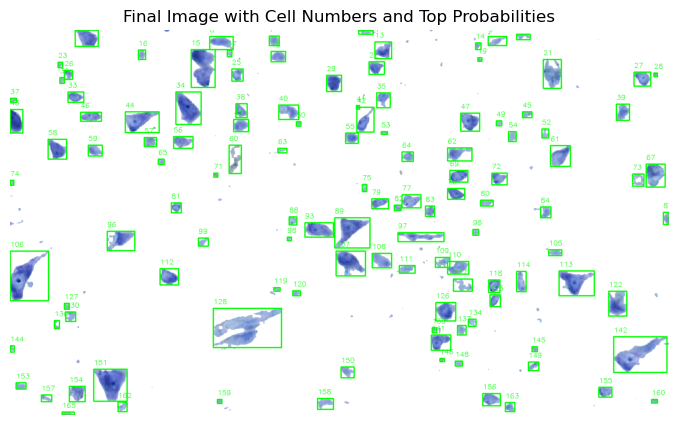

✅ CSV Report Saved: /mnt/data/cell_classifications_with_top_5_probabilities.csv
✅ Final Image Saved: /mnt/data/final_classified_cells_with_probabilities.png


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops, label

# Load the Nissl-stained image
image_path = "restored_white_background_debug.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Adaptive Thresholding for Better Segmentation
_, binary_cells = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small artifacts with morphological operations
kernel = np.ones((3, 3), np.uint8)
binary_cells = cv2.morphologyEx(binary_cells, cv2.MORPH_OPEN, kernel)

# Label the segmented regions
labeled_cells = label(binary_cells)
regions = regionprops(labeled_cells)

# Define Cell Types & Colors
cell_colors = {
    "Pyramidal Neuron": (0, 255, 0),   # Green
    "Stellate Neuron": (255, 255, 0),  # Yellow
    "Astrocyte": (255, 0, 0),          # Red
    "Oligodendrocyte": (0, 0, 255),    # Blue
    "Microglia": (255, 0, 255)         # Magenta
}

# Function to normalize probabilities to sum to 100
def normalize_cell_probabilities(probabilities):
    total = sum(probabilities)
    return [p / total * 100 for p in probabilities]

# Improved Rule-Based Classification with Most Probable Category
def classify_cell(region, cell_region):
    area = region.area
    perimeter = max(region.perimeter, 1)
    aspect_ratio = region.major_axis_length / max(region.minor_axis_length, 1)
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    solidity = region.solidity
    mean_intensity = np.mean(cell_region)
    nucleolus_present = 1 if np.min(cell_region) < 100 else 0  # Adjusted nucleolus threshold

    # **Strict Classification Rules**
    if area > 850 and aspect_ratio > 1.3 and nucleolus_present and circularity < 0.65:
        return "Pyramidal Neuron", {"Pyramidal Neuron": 1.0}
    elif 550 < area < 850 and 1.1 < aspect_ratio < 1.5 and circularity < 0.7:
        return "Stellate Neuron", {"Stellate Neuron": 1.0}
    elif 400 < area < 750 and circularity > 0.5 and mean_intensity > 70:
        return "Astrocyte", {"Astrocyte": 1.0}
    elif area < 550 and circularity > 0.75 and mean_intensity > 90:
        return "Oligodendrocyte", {"Oligodendrocyte": 1.0}
    elif area < 400 and circularity > 0.6 and mean_intensity > 80:
        return "Microglia", {"Microglia": 1.0}

    # **Fallback: Compute Probabilities Based on Features**
    probabilities = {
        "Pyramidal Neuron": np.exp(-abs(area - 900)/200) * np.exp(-abs(aspect_ratio - 1.5)/0.3),
        "Stellate Neuron": np.exp(-abs(area - 700)/200) * np.exp(-abs(aspect_ratio - 1.3)/0.3),
        "Astrocyte": np.exp(-abs(area - 600)/150) * np.exp(-abs(circularity - 0.6)/0.2),
        "Oligodendrocyte": np.exp(-abs(area - 500)/150) * np.exp(-abs(circularity - 0.8)/0.2),
        "Microglia": np.exp(-abs(area - 350)/100) * np.exp(-abs(circularity - 0.65)/0.2)
    }

    return "Fallback", probabilities

# Prepare Data Storage for CSV and Report
cell_data = []

# Apply Rule-Based Classification and Assign Numbers
cell_number = 1  # Starting number for cell labeling
for region in regions:
    if region.area < 50:  # Ignore very small artifacts
        continue

    minr, minc, maxr, maxc = region.bbox
    cell_region = enhanced[minr:maxr, minc:maxc]  # Extract cell region

    # Classify Cell and Get Probabilities
    cell_type, probabilities = classify_cell(region, cell_region)

    # Normalize the top 5 probabilities to sum to 100%
    sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)[:5]
    top_classes = [item[0] for item in sorted_probabilities]
    top_probabilities = [item[1] for item in sorted_probabilities]
    top_probabilities = normalize_cell_probabilities(top_probabilities)

    # Add data for CSV
    centroid_y, centroid_x = region.centroid
    cell_data.append({
        "Cell Number": cell_number,
        "X Coordinate": centroid_x,
        "Y Coordinate": centroid_y,
        "Top 1 Class": top_classes[0],
        "Top 1 Probability": f"{top_probabilities[0]:.1f}%",
        "Top 2 Class": top_classes[1] if len(top_classes) > 1 else "",
        "Top 2 Probability": f"{top_probabilities[1]:.1f}%" if len(top_probabilities) > 1 else "",
        "Top 3 Class": top_classes[2] if len(top_classes) > 2 else "",
        "Top 3 Probability": f"{top_probabilities[2]:.1f}%" if len(top_probabilities) > 2 else "",
        "Top 4 Class": top_classes[3] if len(top_classes) > 3 else "",
        "Top 4 Probability": f"{top_probabilities[3]:.1f}%" if len(top_probabilities) > 3 else "",
        "Top 5 Class": top_classes[4] if len(top_classes) > 4 else "",
        "Top 5 Probability": f"{top_probabilities[4]:.1f}%" if len(top_probabilities) > 4 else ""
    })

    cell_number += 1  # Increment Cell Number

# Convert Data to DataFrame for Display and Save
df = pd.DataFrame(cell_data)

# Save Data to CSV
csv_file_path = "/mnt/data/cell_classifications_with_top_5_probabilities.csv"
df.to_csv(csv_file_path, index=False)

# Display the final image with bounding boxes and top probabilities
output_image_path = "/mnt/data/final_classified_cells_with_probabilities.png"

# Draw bounding boxes and labels for each cell
for region in regions:
    if region.area < 50:  # Skip small regions
        continue
    minr, minc, maxr, maxc = region.bbox
    centroid_y, centroid_x = region.centroid
    label = f"{region.label}"
    cv2.rectangle(image, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    cv2.putText(image, label, (minc, minr - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Save the image with labels
cv2.imwrite(output_image_path, image)

# Show the final image using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Final Image with Cell Numbers and Top Probabilities")
plt.axis("off")
plt.show()

# Output Paths
print(f"✅ CSV Report Saved: {csv_file_path}")
print(f"✅ Final Image Saved: {output_image_path}")


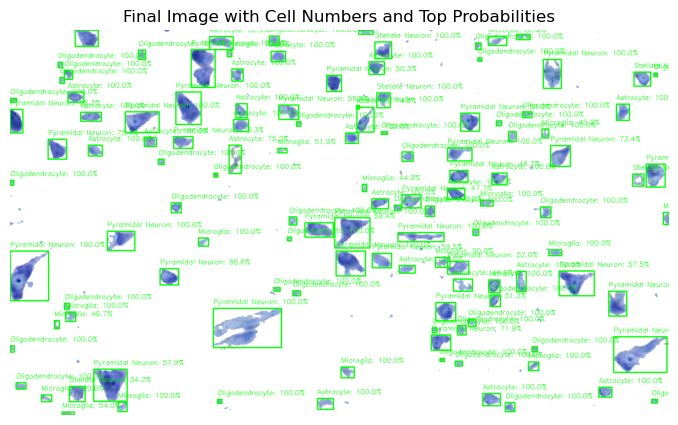

✅ CSV Report Saved: /mnt/data/cell_classifications_with_top_5_probabilities.csv
✅ Final Image Saved: /mnt/data/final_classified_cells_with_probabilities.png


In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops, label

# Load the Nissl-stained image
image_path = "restored_white_background_debug.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Adaptive Thresholding for Better Segmentation
_, binary_cells = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small artifacts with morphological operations
kernel = np.ones((3, 3), np.uint8)
binary_cells = cv2.morphologyEx(binary_cells, cv2.MORPH_OPEN, kernel)

# Label the segmented regions
labeled_cells = label(binary_cells)
regions = regionprops(labeled_cells)

# Define Cell Types & Colors
cell_colors = {
    "Pyramidal Neuron": (0, 255, 0),   # Green
    "Stellate Neuron": (255, 255, 0),  # Yellow
    "Astrocyte": (255, 0, 0),          # Red
    "Oligodendrocyte": (0, 0, 255),    # Blue
    "Microglia": (255, 0, 255)         # Magenta
}

# Function to normalize probabilities to sum to 100
def normalize_cell_probabilities(probabilities):
    total = sum(probabilities)
    return [p / total * 100 for p in probabilities]

# Improved Rule-Based Classification with Most Probable Category
def classify_cell(region, cell_region):
    area = region.area
    perimeter = max(region.perimeter, 1)
    aspect_ratio = region.major_axis_length / max(region.minor_axis_length, 1)
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    solidity = region.solidity
    mean_intensity = np.mean(cell_region)
    nucleolus_present = 1 if np.min(cell_region) < 100 else 0  # Adjusted nucleolus threshold

    # **Strict Classification Rules**
    if area > 850 and aspect_ratio > 1.3 and nucleolus_present and circularity < 0.65:
        return "Pyramidal Neuron", {"Pyramidal Neuron": 1.0}
    elif 550 < area < 850 and 1.1 < aspect_ratio < 1.5 and circularity < 0.7:
        return "Stellate Neuron", {"Stellate Neuron": 1.0}
    elif 400 < area < 750 and circularity > 0.5 and mean_intensity > 70:
        return "Astrocyte", {"Astrocyte": 1.0}
    elif area < 550 and circularity > 0.75 and mean_intensity > 90:
        return "Oligodendrocyte", {"Oligodendrocyte": 1.0}
    elif area < 400 and circularity > 0.6 and mean_intensity > 80:
        return "Microglia", {"Microglia": 1.0}

    # **Fallback: Compute Probabilities Based on Features**
    probabilities = {
        "Pyramidal Neuron": np.exp(-abs(area - 900)/200) * np.exp(-abs(aspect_ratio - 1.5)/0.3),
        "Stellate Neuron": np.exp(-abs(area - 700)/200) * np.exp(-abs(aspect_ratio - 1.3)/0.3),
        "Astrocyte": np.exp(-abs(area - 600)/150) * np.exp(-abs(circularity - 0.6)/0.2),
        "Oligodendrocyte": np.exp(-abs(area - 500)/150) * np.exp(-abs(circularity - 0.8)/0.2),
        "Microglia": np.exp(-abs(area - 350)/100) * np.exp(-abs(circularity - 0.65)/0.2)
    }

    return "Fallback", probabilities

# Prepare Data Storage for CSV and Report
cell_data = []

# Apply Rule-Based Classification and Assign Numbers
cell_number = 1  # Starting number for cell labeling
for region in regions:
    if region.area < 50:  # Ignore very small artifacts
        continue

    minr, minc, maxr, maxc = region.bbox
    cell_region = enhanced[minr:maxr, minc:maxc]  # Extract cell region

    # Classify Cell and Get Probabilities
    cell_type, probabilities = classify_cell(region, cell_region)

    # Normalize the top 5 probabilities to sum to 100%
    sorted_probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)[:5]
    top_classes = [item[0] for item in sorted_probabilities]
    top_probabilities = [item[1] for item in sorted_probabilities]
    top_probabilities = normalize_cell_probabilities(top_probabilities)

    # Add data for CSV
    centroid_y, centroid_x = region.centroid
    cell_data.append({
        "Cell Number": cell_number,
        "X Coordinate": centroid_x,
        "Y Coordinate": centroid_y,
        "Top 1 Class": top_classes[0],
        "Top 1 Probability": f"{top_probabilities[0]:.1f}%",
        "Top 2 Class": top_classes[1] if len(top_classes) > 1 else "",
        "Top 2 Probability": f"{top_probabilities[1]:.1f}%" if len(top_probabilities) > 1 else "",
        "Top 3 Class": top_classes[2] if len(top_classes) > 2 else "",
        "Top 3 Probability": f"{top_probabilities[2]:.1f}%" if len(top_probabilities) > 2 else "",
        "Top 4 Class": top_classes[3] if len(top_classes) > 3 else "",
        "Top 4 Probability": f"{top_probabilities[3]:.1f}%" if len(top_probabilities) > 3 else "",
        "Top 5 Class": top_classes[4] if len(top_classes) > 4 else "",
        "Top 5 Probability": f"{top_probabilities[4]:.1f}%" if len(top_probabilities) > 4 else ""
    })

    # Draw bounding box and label for each cell on the image
    cv2.rectangle(image, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    label_text = f"{top_classes[0]}: {top_probabilities[0]:.1f}%"
    cv2.putText(image, label_text, (minc, minr - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    cell_number += 1  # Increment Cell Number

# Convert Data to DataFrame for Display and Save
df = pd.DataFrame(cell_data)

# Save Data to CSV
csv_file_path = "/mnt/data/cell_classifications_with_top_5_probabilities.csv"
df.to_csv(csv_file_path, index=False)

# Save the final image with labels
output_image_path = "/mnt/data/final_classified_cells_with_probabilities.png"
cv2.imwrite(output_image_path, image)

# Show the final image using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Final Image with Cell Numbers and Top Probabilities")
plt.axis("off")
plt.show()

# Output Paths
print(f"✅ CSV Report Saved: {csv_file_path}")
print(f"✅ Final Image Saved: {output_image_path}")


In [28]:
pip install sweetviz


   ---------------------------------------- 0.0/15.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/15.1 MB 5.6 MB/s eta 0:00:03
   -------- ------------------------------- 3.1/15.1 MB 10.9 MB/s eta 0:00:02
   --------------- ------------------------ 5.8/15.1 MB 12.2 MB/s eta 0:00:01
   --------------- ------------------------ 5.8/15.1 MB 12.2 MB/s eta 0:00:01
   --------------- ------------------------ 5.8/15.1 MB 12.2 MB/s eta 0:00:01
   --------------- ------------------------ 5.8/15.1 MB 12.2 MB/s eta 0:00:01
   --------------- ------------------------ 5.8/15.1 MB 12.2 MB/s eta 0:00:01
   -------------------- ------------------- 7.9/15.1 MB 4.9 MB/s eta 0:00:02
   ------------------------------- -------- 11.8/15.1 MB 6.5 MB/s eta 0:00:01
   --------------------------------- ------ 12.6/15.1 MB 6.9 MB/s eta 0:00:01
   --------------------------------- ------ 12.6/15.1 MB 6.9 MB/s eta 0:00:01
   --------------------------------- ------ 12.6/15.1 MB 6.9 MB/s eta 0:00

In [33]:
import sweetviz as sv
import pandas as pd

# Load your CSV file into a pandas DataFrame
df = pd.read_csv('cell_classifications_with_normalized_probabilities.csv')  # Replace with your actual file path

# Generate the Sweetviz report
report = sv.analyze(df)

# Show the report as an HTML file
report.show_html('sweetviz_report.html')


                                             |                                             | [  0%]   00:00 ->…

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [42]:
import shutil
import os

# Move the Sweetviz report to the 'Brain Lab' folder
shutil.move('sweetviz_report.html', os.path.join('Brain Lab', 'sweetviz_report.html'))



'Brain Lab\\sweetviz_report.html'

In [9]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops, label
from scipy.ndimage import uniform_filter

# Load Nissl-Stained Image
image_path = "restored_white_background_debug.png" 
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Adaptive Thresholding for Better Segmentation
_, binary_cells = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small artifacts with morphological operations
kernel = np.ones((3, 3), np.uint8)
binary_cells = cv2.morphologyEx(binary_cells, cv2.MORPH_OPEN, kernel)

# Label the segmented regions
labeled_cells = label(binary_cells)
regions = regionprops(labeled_cells)

# Compute Local Homogeneity with fixes
def local_homogeneity(image, window_size=3):
    mean_local = uniform_filter(image, size=window_size)
    variance_local = uniform_filter(image**2, size=window_size) - mean_local**2
    epsilon = 1e-6  # Small value to avoid division by zero
    variance_local = np.maximum(variance_local, epsilon)  # Ensure no zero variance
    homogeneity = 1 / (1 + variance_local)
    
    # Normalize properly
    min_h = np.min(homogeneity)
    max_h = np.max(homogeneity)
    if max_h > min_h:  # Prevent division by zero
        homogeneity = (homogeneity - min_h) / (max_h - min_h)
    else:
        homogeneity = np.zeros_like(homogeneity)  # If no variation, set to zero
    
    return homogeneity

homogeneity_map = local_homogeneity(enhanced)

# Prepare Data Storage for CSV and Table
cell_data = []

# Extract Features
cell_number = 1  # Starting number for cell labeling
for region in regions:
    if region.area < 50:  # Ignore very small artifacts
        continue

    minr, minc, maxr, maxc = region.bbox
    cell_region = enhanced[minr:maxr, minc:maxc]  # Extract cell region
    homogeneity_value = np.mean(homogeneity_map[minr:maxr, minc:maxc])

    # Add Data for CSV and Table
    cell_data.append({
        "Cell Number": cell_number,
        "Area": region.area,
        "Perimeter": region.perimeter,
        "Major Axis Length": region.major_axis_length,
        "Minor Axis Length": region.minor_axis_length,
        "Soma Diameter": region.equivalent_diameter,  # Approximation
        "Aspect Ratio": region.major_axis_length / max(region.minor_axis_length, 1),
        "Circularity": (4 * np.pi * region.area) / (region.perimeter ** 2),
        "Solidity": region.solidity,
        "Nucleolus Present": 1 if np.min(cell_region) < 100 else 0,
        "Local Homogeneity": round(homogeneity_value, 6)  # Round for precision
    })

    cell_number += 1  # Increment Cell Number

# Convert Data to DataFrame for Display and Save
df = pd.DataFrame(cell_data)

# Save Data to CSV
csv_path = "Brain Lab/data_cell_for_clustering.csv"
df.to_csv(csv_path, index=False)

# Output Path
print(f"✅ CSV Data Saved: {csv_path}")


✅ CSV Data Saved: Brain Lab/data_cell_for_clustering.csv


In [13]:
import cv2
import numpy as np
import pandas as pd
from skimage.measure import regionprops, label
from scipy.ndimage import uniform_filter

# Load Nissl-Stained Image
image_path = "restored_white_background_debug.png" 
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Adaptive Thresholding for Better Segmentation
_, binary_cells = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small artifacts with morphological operations
kernel = np.ones((3, 3), np.uint8)
binary_cells = cv2.morphologyEx(binary_cells, cv2.MORPH_OPEN, kernel)

# Label the segmented regions
labeled_cells = label(binary_cells)
regions = regionprops(labeled_cells)

# Compute Local Homogeneity with fixes
def local_homogeneity(image, window_size=3):
    mean_local = uniform_filter(image, size=window_size)
    variance_local = uniform_filter(image**2, size=window_size) - mean_local**2
    epsilon = 1e-6  # Small value to avoid division by zero
    variance_local = np.maximum(variance_local, epsilon)  # Ensure no zero variance
    homogeneity = 1 / (1 + variance_local)
    
    # Normalize properly
    min_h = np.min(homogeneity)
    max_h = np.max(homogeneity)
    if max_h > min_h:  # Prevent division by zero
        homogeneity = (homogeneity - min_h) / (max_h - min_h)
    else:
        homogeneity = np.zeros_like(homogeneity)  # If no variation, set to zero
    
    return homogeneity

homogeneity_map = local_homogeneity(enhanced)

# Prepare Data Storage for CSV and Table
cell_data = []

# Extract Features
cell_number = 1  # Starting number for cell labeling
for region in regions:
    if region.area < 50:  # Ignore very small artifacts
        continue

    minr, minc, maxr, maxc = region.bbox
    homogeneity_value = np.mean(homogeneity_map[minr:maxr, minc:maxc])

    # Add Data for CSV and Table
    cell_data.append({
        "Cell Number": cell_number,
        "Area": region.area,
        "Perimeter": region.perimeter,
        "Major Axis Length": region.major_axis_length,
        "Minor Axis Length": region.minor_axis_length,
        "Soma Diameter": region.equivalent_diameter,  # Approximation
        "Aspect Ratio": region.major_axis_length / max(region.minor_axis_length, 1),
        "Circularity": (4 * np.pi * region.area) / (region.perimeter ** 2),
        "Solidity": region.solidity,
        "Local Homogeneity": round(homogeneity_value, 6)  # Round for precision
    })

    cell_number += 1  # Increment Cell Number

# Convert Data to DataFrame for Display and Save
df = pd.DataFrame(cell_data)

# Save Data to CSV
csv_path = "Brain Lab/data_cell_for_clustering.csv"
df.to_csv(csv_path, index=False)

# Output Path
print(f"✅ CSV Data Saved: {csv_path}")


✅ CSV Data Saved: Brain Lab/data_cell_for_clustering.csv


Cell Features Table:
     Cell Number         Cell Type    Area   Perimeter  Major Axis Length  \
0              1  Pyramidal Neuron  1255.0  147.982756          49.747462   
1              2         Microglia   228.0   72.727922          32.114320   
2              3         Microglia   203.0   77.112698          32.737876   
3              4   Oligodendrocyte   379.0   70.284271          22.729234   
4              5  Pyramidal Neuron   861.0  142.568542          52.004324   
..           ...               ...     ...         ...                ...   
116          117   Oligodendrocyte    76.0   30.485281          11.172082   
117          118   Oligodendrocyte    88.0   34.485281          13.837417   
118          119         Microglia   241.0   65.698485          24.354868   
119          120   Oligodendrocyte   289.0   65.112698          21.572100   
120          121         Microglia   135.0   57.520815          27.326301   

     Minor Axis Length  Soma Diameter  Aspect Ratio  C

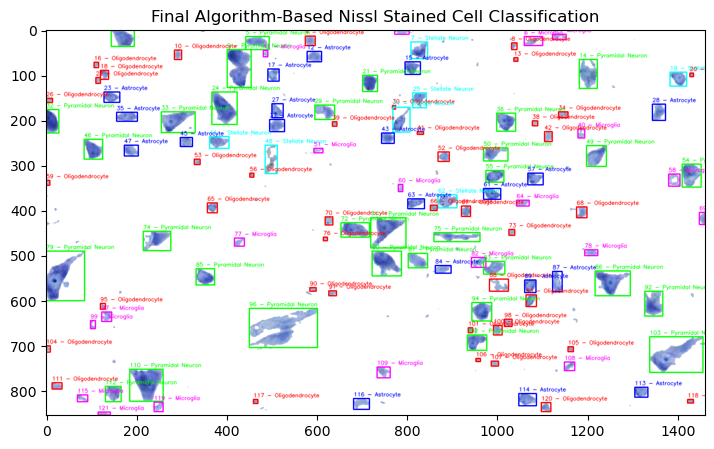

✅ CSV Data Saved: data_cell_with_centroids.csv
✅ Final Image Saved: /mnt/data/final_classified_nissl_cells_with_centroids.png


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import regionprops, label

# Load Nissl-Stained Image
image_path = "restored_white_background_debug.png" 
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply CLAHE for contrast enhancement
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
enhanced = clahe.apply(gray)

# Adaptive Thresholding for Better Segmentation
_, binary_cells = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Remove small artifacts with morphological operations
kernel = np.ones((3, 3), np.uint8)
binary_cells = cv2.morphologyEx(binary_cells, cv2.MORPH_OPEN, kernel)

# Label the segmented regions
labeled_cells = label(binary_cells)
regions = regionprops(labeled_cells)

# Define Cell Types & Colors
cell_colors = {
    "Pyramidal Neuron": (0, 255, 0),   # Green
    "Stellate Neuron": (255, 255, 0),  # Yellow
    "Astrocyte": (255, 0, 0),          # Red
    "Oligodendrocyte": (0, 0, 255),    # Blue
    "Microglia": (255, 0, 255)         # Magenta
}

# **Improved Rule-Based Classification with Most Probable Category**
def classify_cell(region, cell_region):
    area = region.area
    perimeter = max(region.perimeter, 1)
    aspect_ratio = region.major_axis_length / max(region.minor_axis_length, 1)
    circularity = (4 * np.pi * area) / (perimeter ** 2)
    solidity = region.solidity
    mean_intensity = np.mean(cell_region)
    nucleolus_present = 1 if np.min(cell_region) < 100 else 0  # Adjusted nucleolus threshold

    # **Strict Classification Rules**
    if area > 850 and aspect_ratio > 1.3 and nucleolus_present and circularity < 0.65:
        return "Pyramidal Neuron"

    elif 550 < area < 850 and 1.1 < aspect_ratio < 1.5 and circularity < 0.7:
        return "Stellate Neuron"

    elif 400 < area < 750 and circularity > 0.5 and mean_intensity > 70:
        return "Astrocyte"

    elif area < 550 and circularity > 0.75 and mean_intensity > 90:
        return "Oligodendrocyte"

    elif area < 400 and circularity > 0.6 and mean_intensity > 80:
        return "Microglia"

    # **Fallback: Assign to the Closest Matching Cell Type**
    distances = {
        "Pyramidal Neuron": abs(area - 900) + abs(aspect_ratio - 1.5) + abs(mean_intensity - 60),
        "Stellate Neuron": abs(area - 700) + abs(aspect_ratio - 1.3) + abs(mean_intensity - 75),
        "Astrocyte": abs(area - 600) + abs(circularity - 0.6) + abs(mean_intensity - 85),
        "Oligodendrocyte": abs(area - 500) + abs(circularity - 0.8) + abs(mean_intensity - 95),
        "Microglia": abs(area - 350) + abs(circularity - 0.65) + abs(mean_intensity - 90)
    }

    return min(distances, key=distances.get)  # Assign the cell to the category with the smallest "distance"

# Prepare Data Storage for CSV and Table
cell_data = []

# Apply Rule-Based Classification and Assign Numbers
cell_number = 1  # Starting number for cell labeling
for region in regions:
    if region.area < 50:  # Ignore very small artifacts
        continue

    minr, minc, maxr, maxc = region.bbox
    cell_region = enhanced[minr:maxr, minc:maxc]  # Extract cell region

    # Classify Cell
    cell_type = classify_cell(region, cell_region)
    color = cell_colors.get(cell_type, (255, 255, 255))  # Default white if not found

    # Draw Bounding Box, Label and Number for Cell
    cv2.rectangle(image, (minc, minr), (maxc, maxr), color, 2)
    cv2.putText(image, f"{cell_number} - {cell_type}", (minc, minr - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)

    # Add Data for CSV and Table with Centroid Coordinates
    cell_data.append({
        "Cell Number": cell_number,
        "Cell Type": cell_type,
        "Area": region.area,
        "Perimeter": region.perimeter,
        "Major Axis Length": region.major_axis_length,
        "Minor Axis Length": region.minor_axis_length,
        "Soma Diameter": region.equivalent_diameter,  # Approximation
        "Aspect Ratio": region.major_axis_length / max(region.minor_axis_length, 1),
        "Circularity": (4 * np.pi * region.area) / (region.perimeter ** 2),
        "Solidity": region.solidity,
        "Nucleolus Present": 1 if np.min(cell_region) < 100 else 0,
        "X Centroid": region.centroid[1],  # X coordinate
        "Y Centroid": region.centroid[0]   # Y coordinate
    })

    cell_number += 1  # Increment Cell Number

# Convert Data to DataFrame for Display and Save
df = pd.DataFrame(cell_data)

# Display Table in Output
print("Cell Features Table:")
print(df)

# Save Data to CSV
csv_path = "data_cell_with_centroids.csv"
df.to_csv(csv_path, index=False)

# Save Final Image
output_image_path = "/mnt/data/final_classified_nissl_cells_with_centroids.png"
cv2.imwrite(output_image_path, image)

# Display Image
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Final Algorithm-Based Nissl Stained Cell Classification")
plt.axis('on')  # Show X and Y axes
plt.show()

# Output Paths
print(f"✅ CSV Data Saved: {csv_path}")
print(f"✅ Final Image Saved: {output_image_path}")

